# Trainer server runtimes BTS/STB

In [1]:
DATASET = "fmow"

# accuracies log
PATH3 = f"../clean_data/sgs3/stream/{DATASET}/accuracies.json"
PATH4 = f"../clean_data/sgs4/stream/{DATASET}/accuracies.json"

# trainer server timings logs
PATH3_TS = f"../clean_data/sgs3/stream/{DATASET}/new_logs_backup"
PATH4_TS = f"../clean_data/sgs4/stream/{DATASET}/new_logs_backup"

KEEP_INCOMPLETE_MEASUREMENTS = False

In [2]:
import json
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from utils.process_log_averages import get_timings_summary_clean
from chart_style_mpl import set_size
import pylab
import scienceplots

In [3]:
TITLE_COLOR = "#FC6A49"
if DATASET == "fmow":
    TITLE_COLOR = "#6F9074"
elif DATASET == "huffpost":
    TITLE_COLOR = "#745474"

## Data loading


In [4]:
config_total = json.load(open("../config_total.json", "r"))
summary_time = pd.DataFrame(get_timings_summary_clean(PATH3_TS, PATH4_TS, config_total)).T

Missing logs for GradMatch_25pc_10ep_reset_STB: 'GradMatch_25pc_10ep_reset_STB'
Missing logs for Loss_25pc_10ep_reset_STB: 'Loss_25pc_10ep_reset_STB'
Missing logs for all_data_8ep: 'all_data_8ep'


In [5]:
with open(PATH3, "r") as f:
    data3 = json.load(f)
with open(PATH4, "r") as f:
    data4 = json.load(f)
df3 = pd.DataFrame(data3)
df4 = pd.DataFrame(data4)

accuracies = df3.merge(df4, on=['Experiment', 'Model trigger'], how='outer', suffixes=('_sgs3', '_sgs4'))
accuracies['average'] = (accuracies['top1_sgs3'] + accuracies['top1_sgs4']) / 2
if not KEEP_INCOMPLETE_MEASUREMENTS:
    accuracies = accuracies.dropna(subset=['top1_sgs3', 'top1_sgs4'])

accuracies = accuracies.rename(columns={'top1_sgs3': 'sgs3', 'top1_sgs4': 'sgs4'})
accuracies = accuracies[['Experiment', 'Model trigger', 'average', 'sgs3', 'sgs4']]
accuracies = accuracies.groupby("Experiment").mean()

In [ ]:
merged_df = pd.merge(accuracies, summary_time, left_index=True, right_index=True)
groups = {
        "STB": ["Gradnorm_25pc_10ep_reset_STB", "Loss_25pc_10ep_reset_STB", "Craig_25pc_10ep_reset_STB", "GradMatch_25pc_10ep_reset_STB", "SubmodularFL_25pc_10ep_reset_STB", "Margin_25pc_10ep_reset_STB", "Kcenter_25pc_10ep_reset_STB", "SubmodularGC_25pc_10ep_reset_STB", "SubmodularLD_25pc_10ep_reset_STB"],
        "BTS": ["Gradnorm_25pc_10ep_reset", "Loss_25pc_10ep_reset", "Craig_25pc_10ep_reset", "GradMatch_25pc_10ep_reset", "SubmodularFL_25pc_10ep_reset", "Margin_25pc_10ep_reset", "Kcenter_25pc_10ep_reset", "SubmodularGC_25pc_10ep_reset", "SubmodularLD_25pc_10ep_reset"],
        "P_50": ["random_50pc_10ep_reset", "labelBalanced_50pc_10ep_reset"],
        "P_25": ["random_25pc_10ep_reset","labelBalanced_25pc_10ep_reset"],
        "A": ["all_data_2ep_reset", "all_data_5ep_reset", "all_data_10ep_reset"]
    }

macrogroups = {
    "P": ["P_50", "P_25"],
    "BTS": ["BTS"],
    "STB": ["STB"],
    "All": ["A"],
}

labels = []
mgroups = []
for experiment in merged_df.index.to_list():
    found = False
    for key in groups:
        if experiment in groups[key]:
            labels.append(key)
            for mgroup in macrogroups:
                if key in macrogroups[mgroup]:
                    mgroups.append(mgroup)
            found = True
            break
    if not found:
        labels.append("Extra")
        mgroups.append("Extra")
merged_df["group"] = labels
merged_df["experiment"] = merged_df.index
merged_df["macrogroup"] = mgroups
merged_df["training"] = merged_df["trigger"]
merged_df["short_name"] = merged_df.experiment.apply(lambda x : x.split("_")[0])


# Time vs Accuracy scatter plot

Expected output:
![timevsAcc](../demo_out/Accuracies_scatterfmow.png)

In [11]:
def add_plot_general(axis, data):

    color_mapping = {
            "BTS": "r",
            "STB": "g",
            "P": "b",
            "All": "orange",
            "Extra": "purple"
        }
    colors = data["macrogroup"].map(color_mapping)
    colors = list(colors.values)

    # Create a Matplotlib scatter plot with colors based on the column containing category names
    axis.scatter(data["trigger"], data["average"], c=colors, marker='o', s=50)
    axis.set_xlabel("Training Time")
    axis.set_ylabel("Average Accuracy")
    
    legend_elements = [
                   Line2D([0], [0], marker='o', color='w', label='\\textbf{Group BTS}: Batch-Then-Sample',
                          markerfacecolor='r', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='\\textbf{Group STB}: Sample-Then-Batch',
                          markerfacecolor='g', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='\\textbf{Group P}: Presamplers (25\% and 50\%)',
                          markerfacecolor='b', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='\\textbf{Group All}: All data',
                          markerfacecolor='orange', markersize=10)
                  ]

    axis.legend(handles=legend_elements, frameon = True)

def add_plot(axis, data, global_plot = False):
    i = 0
    colors = ["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "tab:purple", "darkslategrey", "mediumspringgreen", "palevioletred", "navy"]*10
    for index, data in data.sort_index().iterrows():
        if not("random" in index or "label" in index or "all" in index):
            index = index.split("_")[0]
        else:
            index = index.split("_reset")[0]
        axis.scatter(data["trigger"], data["average"], c=colors[i], marker='o', s=50, label=index)
        i=i+1

    axis.legend(ncol=2, prop={'size': 8}, frameon=True)
    axis.set_xlabel("Training Time")
    axis.set_ylabel("Average Accuracy")



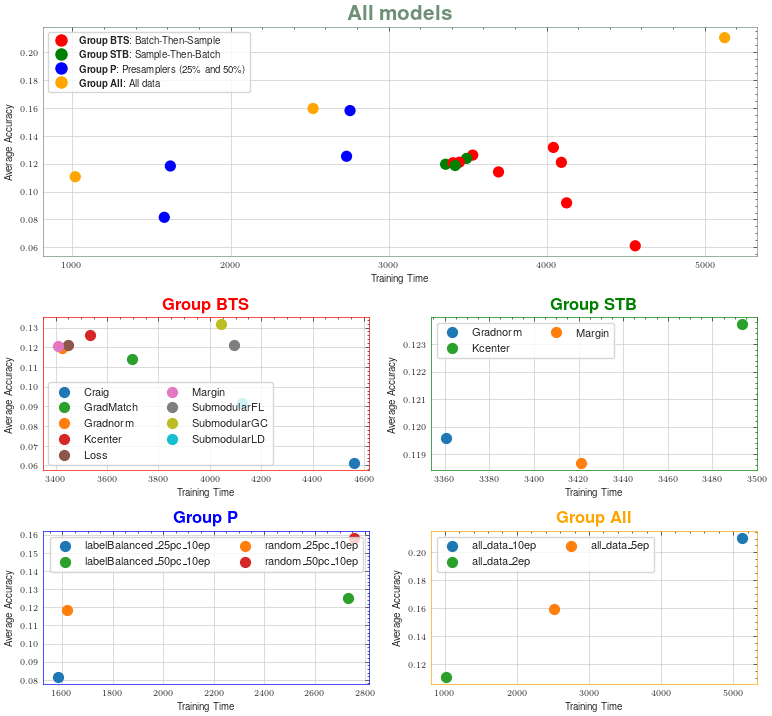

In [18]:
plt.cla()
plt.clf()
plt.close()

fig = plt.figure()

plt.style.use(['science'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "Helvetica",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 8,
    "font.size": 8,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

merged_df = merged_df[merged_df['group'] != 'Extra']

plt.rcParams['figure.figsize'] = set_size(fraction=1.5, subplots=(3,2))



axs = fig.subplot_mosaic([['Big', "Big"],['25', '50'], ["75", "100"]],
                          gridspec_kw={'height_ratios':[1.5, 1, 1]}, sharey=False)
axs['Big'].set_title(r'\textbf{All models}', size=15, color = TITLE_COLOR)
add_plot_general(axs["Big"], merged_df)
axs['25'].set_title(r'\textbf{Group BTS}', color = "r", size=12)
add_plot(axs["25"], merged_df[merged_df["group"].isin(macrogroups["BTS"])])
axs['50'].set_title(r'\textbf{Group STB}', color= "g", size=12)
add_plot(axs["50"], merged_df[merged_df["group"].isin(macrogroups["STB"])])
axs['75'].set_title(r'\textbf{Group P}', color="b", size=12)
add_plot(axs["75"], merged_df[merged_df["group"].isin(macrogroups["P"])])
axs['100'].set_title(r'\textbf{Group All}', color="orange", size=12)
add_plot(axs["100"], merged_df[merged_df["group"].isin(macrogroups["All"])])


colors = {"25": "r", "50": "g", "75": "b", "100": "orange", "Big": TITLE_COLOR}

for subchart in colors:
    axs[subchart].spines['bottom'].set_color(colors[subchart])
    axs[subchart].spines['top'].set_color(colors[subchart])
    axs[subchart].spines['right'].set_color(colors[subchart])
    axs[subchart].spines['left'].set_color(colors[subchart])
fig.tight_layout()
plt.savefig(f"out_clean/Accuracies_scatter{DATASET}.pdf", format='pdf', bbox_inches='tight')

# Trainer server times for downsampling strategies

Expected output:
![selector_time](../demo_out/BTS_fmow.png)

In [19]:
###### PREPROCESSING ######
data_df = merged_df[merged_df.group.isin(["BTS", "A"])].copy()
config_bts = json.load(open("../config_histograms/config_bts.json", "r"))
summary_time_bts = pd.DataFrame(get_timings_summary_clean(PATH3_TS, PATH4_TS, config_bts, cleaned= DATASET == "yearbook")).T
config_all = json.load(open("../config_histograms/config_all.json", "r"))
summary_time_all = pd.DataFrame(get_timings_summary_clean(PATH3_TS, PATH4_TS, config_all, cleaned= DATASET == "yearbook")).T
summary_time_bts.loc[summary_time_bts.index.str.startswith("all_data_"),"training forward"] = summary_time_all[summary_time_all.index.str.startswith("all_data_")]["forward pass"]
data_df2 = pd.merge(data_df, summary_time_bts, left_index=True, right_index=True)
data_df2["Experiment"] = data_df2.index
data_df2["Experiment"] = data_df2["Experiment"].apply(lambda x: x.split("_")[0] if "all" not in x else "all, " + x.split("_")[2])
data_df2.set_index("Experiment", inplace=True)
data_df2 = data_df2.sort_values(by="trigger", ascending=True)
data_df2 = data_df2[data_df2["experiment"] != "all_data_5ep_reset"]
chart_df = data_df2[["preprocessing", "BTS forward", "BTS compute scores", "BTS select samples", "training forward", "backward pass", "optimizer step"]]
###### PREPROCESSING ######

Missing logs for GradMatch_25pc_10ep_reset_STB: 'GradMatch_25pc_10ep_reset_STB'
Missing logs for Loss_25pc_10ep_reset_STB: 'Loss_25pc_10ep_reset_STB'
Missing logs for all_data_8ep: 'all_data_8ep'
Missing logs for GradMatch_25pc_10ep_reset_STB: 'GradMatch_25pc_10ep_reset_STB'
Missing logs for Loss_25pc_10ep_reset_STB: 'Loss_25pc_10ep_reset_STB'
Missing logs for all_data_8ep: 'all_data_8ep'


Chart_df must be a dataframe with the sum of runtimes as columns (ex ['preprocessing', 'BTS forward', 'BTS compute scores', 'BTS select samples', 'training forward', 'backward pass', 'optimizer step']) and the experiment name as index. For example, a row of chart_df could be 
{'preprocessing': 109.83643500000001, 'BTS forward': 0.0, 'BTS compute scores': 0.0, 'BTS select samples': 0.0, 'training forward': 150.54721, 'backward pass': 183.00002, 'optimizer step': 287.038625}

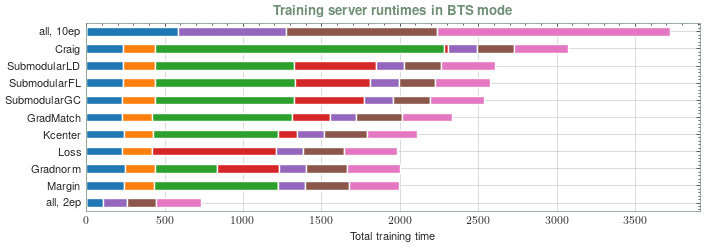

In [22]:
fig, ax= plt.subplots(1, 1,)
chart_df.plot(stacked=True, kind = "barh", ax = ax, color = [mpl.colormaps["tab10"](i) for i in range(10)])
plt.legend(ncol=2, frameon=True, edgecolor = TITLE_COLOR)

plt.style.use(['science'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
tex_fonts = {
    "text.usetex": True,
    "font.family": "Helvetica",
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.rcParams['figure.figsize'] = set_size(fraction=1.5, subplots=(1,2))
plt.rcParams.update(tex_fonts)
plt.xlabel("Total training time")
plt.ylabel("")
plt.title(r"\textbf{Training server runtimes in BTS mode}", color=TITLE_COLOR)
#plt.grid()
ax.spines['bottom'].set_color(TITLE_COLOR)
ax.spines['top'].set_color(TITLE_COLOR)
ax.spines['right'].set_color(TITLE_COLOR)
ax.spines['left'].set_color(TITLE_COLOR)
ax.get_legend().remove()
plt.savefig(f"out_clean/BTS_{DATASET}.pdf", format='pdf', bbox_inches='tight', transparent=True)


The cell below generates a standalone legend

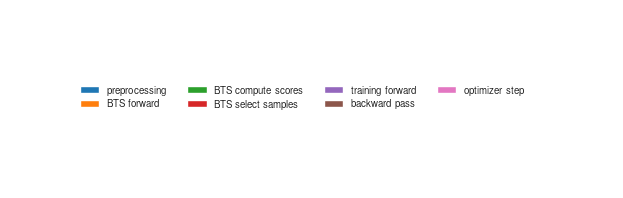

In [23]:
label_params, labN = ax.get_legend_handles_labels()

plt.style.use(['science'])
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "Helvetica",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 7,
    "font.size": 9,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 7,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
}
plt.rcParams.update(tex_fonts)
size = set_size(fraction=1.5, subplots=(1.5,3))
size = (size[0], size[1] )
fig, axl = plt.subplots(figsize=size)
axl.axis(False)
legend = pylab.figlegend(label_params , labN , loc="center", bbox_to_anchor=(0.5, 0.5), ncol = 4, frameon=False)
fig.canvas.draw()
fig.savefig(f"out_clean/BTS_legend.pdf", format='pdf', transparent=True, bbox_inches=legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted()))